In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Any

import sys
import os

from meteostat import Point, Daily
from datetime import datetime

src_path = os.path.abspath(os.path.join(os.getcwd(), "..", "src"))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

from gratis_precip.features.base_features import *
from gratis_precip.features.precip_features import *


from gratis_precip.features import FeatureExtractor

import warnings

warnings.filterwarnings("ignore")

import logging

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

from gratis_precip.models import ARMAComponent, CompositeComponent, MARDataGenerator

from gratis_precip.dimensionality_reduction import PCAReduction, DimensionalityReducer

from gratis_precip.optimization import GARun

### Step 1: Fetch the target precipitation data

In [2]:

def fetch_precipitation_data():
    location = Point(47.368011576362896, 8.5387625442684280)  # Zurich
    start = datetime(1986, 1, 1)
    end = datetime(2023, 12, 31)
    data = Daily(location, start, end)
    data = data.fetch()
    return data['prcp']

target_data = fetch_precipitation_data()

### Step 2: Create the MAR model

In [3]:
def create_mar_model(data: pd.Series, n_components: int = 3):
    components = [
        ARMAComponent(order=(1, 1), weight=1/n_components),
        ARMAComponent(order=(2, 1), weight=1/n_components),
        ARMAComponent(order=(1, 2), weight=1/n_components)
    ]
    composite = CompositeComponent(components)
    mar_generator = MARDataGenerator(composite, steps=len(data))
    mar_generator.fit(data)
    return mar_generator

mar_model = create_mar_model(target_data)

### Step 3: Set up the feature extractor

In [4]:
feature_extractors = [
    TotalPrecipitation(),
    PrecipitationIntensity(),
    DrySpellDuration(),
    WetSpellDuration(),
    PrecipitationVariability(),
    ExtremePrecipitationFrequency(),
    MaximumDailyPrecipitation(),
    WetDayFrequency(),
    MeanPrecipitation(),
    MinimumDailyPrecipitation(),
    # TrendFeature(),
    # SeasonalStrengthFeature(),
    # SpikeFeature(),
    # LinearityFeature(),
]
feature_extractor = FeatureExtractor(feature_extractors)

### Step 4: Set up the dimensionality reducer

In [5]:
pca_reduction = PCAReduction(n_components=2)
dimensionality_reducer = DimensionalityReducer(pca_reduction)

### Step 5: Create and run the genetic algorithm

In [16]:
ga_run = GARun(
    mar_model=mar_model,
    feature_extractor=feature_extractor,
    dimensionality_reducer=dimensionality_reducer,
    target_time_series=target_data.values,
    num_generations=500,
    population_size=40,
    num_parents_mating=10
)

best_solution = ga_run.run()

2024-07-13 10:22:57,443 - INFO - Starting genetic algorithm run
2024-07-13 10:22:57,444 - INFO - Genetic algorithm initialized. Starting evolution.
2024-07-13 10:22:57,445 - INFO - Generating 1 trajectories...
2024-07-13 10:22:57,471 - INFO - Final generated trajectories:
2024-07-13 10:22:57,474 - INFO -               Sim_1
count  12952.000000
mean       1.871687
std        3.086730
min        0.000000
25%        0.683914
50%        1.260134
75%        2.160350
max      112.718971
2024-07-13 10:22:57,478 - INFO - Generating 1 trajectories...
2024-07-13 10:22:57,498 - INFO - Final generated trajectories:
2024-07-13 10:22:57,500 - INFO -               Sim_1
count  12963.000000
mean       1.905284
std        3.585245
min        0.000000
25%        0.722984
50%        1.303707
75%        2.175343
max      144.353718
2024-07-13 10:22:57,503 - INFO - Generating 1 trajectories...
2024-07-13 10:22:57,523 - INFO - Final generated trajectories:
2024-07-13 10:22:57,526 - INFO -               Sim_

### Step 6: Generate optimized time series

In [12]:
mar_model.update_weights(best_solution)
optimized_data = mar_model.generate(n_trajectories=6)

2024-07-13 10:22:27,583 - INFO - Generating 6 trajectories...
2024-07-13 10:22:27,698 - INFO - Final generated trajectories:
2024-07-13 10:22:27,705 - INFO -               Sim_1         Sim_2         Sim_3         Sim_4         Sim_5  \
count  12933.000000  12951.000000  12916.000000  12870.000000  12942.000000   
mean       1.866367      1.844676      1.920374      1.816435      1.938970   
std        3.614890      2.846012      4.714460      3.218369      5.248706   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.695109      0.693713      0.701847      0.669171      0.698371   
50%        1.275600      1.254172      1.276253      1.245243      1.292305   
75%        2.172532      2.150602      2.185293      2.114850      2.163759   
max      217.544948    110.939450    401.777632    188.398578    373.239727   

              Sim_6  
count  12944.000000  
mean       1.814212  
std        2.717169  
min        0.000000  
25%        0.675471 

In [13]:
optimized_data

Sim_1     Sim_2     Sim_3      Sim_4     Sim_5     Sim_6
time                                                                    
1986-01-01  58.439003  0.393625  0.081135   1.674404  0.897597  0.302387
1986-01-02        NaN  0.570322  0.222273   1.241569  3.087544  2.227334
1986-01-03   3.244258  2.934577  0.576382   2.849663  0.206530  1.309283
1986-01-04   2.683061  0.903188  0.620466   1.170246  0.698240  2.775562
1986-01-05   0.774329  0.932063  3.642924   0.576721  1.263931  1.246690
...               ...       ...       ...        ...       ...       ...
2023-12-27   0.458135  0.837907  0.285022   0.194217  3.907853  3.562924
2023-12-28   0.454312  0.595225  2.809760  72.053142  0.436886  2.858348
2023-12-29        NaN  0.457582  0.279171   1.582707  1.476475  0.373418
2023-12-30   1.182202  0.000000  0.626557   2.422874  0.818661  0.136487
2023-12-31   5.298989  0.537272  0.249353   0.956005  1.397798  0.971624

[13879 rows x 6 columns]

### Step 7: Visualize results

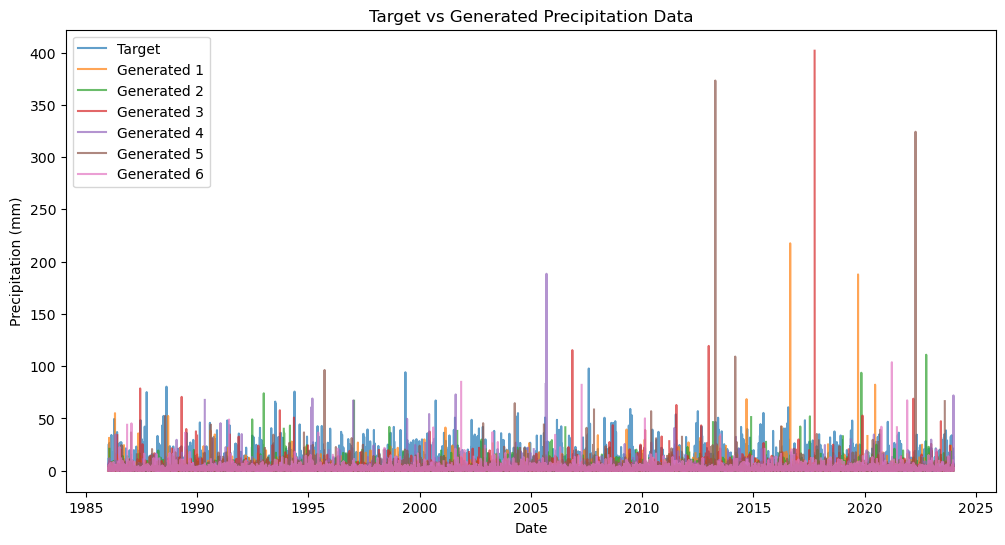

2024-07-13 10:22:31,345 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


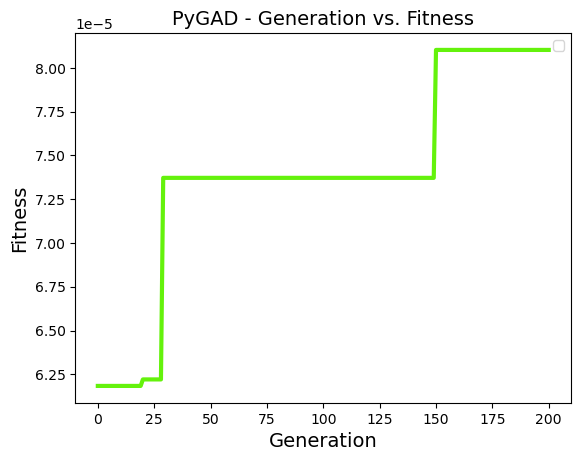

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(target_data.index, target_data.values, label="Target", alpha=0.7)
for i in range(1, 7):
    plt.plot(
        target_data.index, optimized_data[f"Sim_{i}"], label=f"Generated {i}", alpha=0.7
    )
plt.legend()
plt.title("Target vs Generated Precipitation Data")
plt.xlabel("Date")
plt.ylabel("Precipitation (mm)")
plt.show()

# Optional: Plot fitness evolution
ga_run.plot_fitness_evolution()

### Look at the features

In [15]:
# Access target features
target_features = ga_run.get_target_features()
print(target_features)

# Access best generated features
best_generated_features = ga_run.get_generated_features()
print(best_generated_features)

[4.23232000e+04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 6.30372356e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.49770009e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.88505747e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.15306916e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 5.00036026e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.78000000e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000